## One Billion Row Challenge

💪 The challenge

Your mission, should you choose to accept it, is to write a program that retrieves temperature measurement values from a text file and calculates the min, mean, and max temperature per weather station. There's just one caveat: the file has 1,000,000,000 rows! That's more than 10 GB of data! 😱



## 1-  Pure Python
Time elapsed: 594.89 seconds ~ 10 minutes



In [33]:
import time
from tqdm import tqdm

def read_and_calculate_stats(file_name):
    city_stats = {}
    with open(file_name, 'r') as file:
        for line in tqdm(file, desc="Processing data"):
            line = line.strip()  # Strip whitespace
            if not line or ';' not in line:  # Skip empty lines or lines without ;
                continue
            city, temp = line.split(';', maxsplit=1)  # Split only at first ;
            try:
                temp = float(temp)
            except ValueError:  # Handle invalid temperature values
                print(f"Warning: Invalid temperature value '{temp}' for city '{city}'")
                continue  

            if city in city_stats:
                stats = city_stats[city]
                stats['count'] += 1
                stats['total'] += temp
                if temp < stats['min']:
                    stats['min'] = temp
                if temp > stats['max']:
                    stats['max'] = temp
            else:
                city_stats[city] = {
                    'min': temp,
                    'max': temp,
                    'total': temp,
                    'count': 1
                }

    # Calculate mean from total and count
    for city, stats in city_stats.items():
        stats['mean'] = stats['total'] / stats['count']
        del stats['total'], stats['count']  # Optional: Remove these if no longer needed

    return city_stats

# Main execution
start_time = time.time()
city_stats = read_and_calculate_stats('data/measurements.txt')
end_time = time.time()

print('Helsinki',city_stats['Helsinki'])
print('Guatemala City,',city_stats['Guatemala City'],'\n')

print(f"Time elapsed: {end_time - start_time:.2f} seconds")


Processing data: 1000000001it [09:54, 1680983.16it/s]

Helsinki {'min': -46.8, 'max': 55.3, 'mean': 5.90051665154234}
Guatemala City, {'min': -32.3, 'max': 69.5, 'mean': 20.39640808762602} 

Time elapsed: 594.89 seconds


## 2- Pandas
Elapsed Time: 155.37 seconds

In [8]:
import pandas as pd
import time
from tqdm import tqdm

def process_data(file_path, chunk_size=1000000):
    start_time = time.time()  # Start timing

    # Initialize an empty DataFrame to accumulate results
    accumulated_results = pd.DataFrame()

    # Initialize reader object
    reader = pd.read_csv(file_path, sep=';', header=None, names=['city', 'temp'], chunksize=chunk_size)

    # Process each chunk
    for chunk in tqdm(reader, desc="Processing chunks"):
        # Group by 'city' and calculate min, max, and mean for the chunk
        results = chunk.groupby('city')['temp'].agg(['min', 'max', 'mean']).rename(columns={
            'min': 'temperature_min',
            'max': 'temperature_max',
            'mean': 'temperature_mean'
        })
        # Append chunk results to the accumulated results
        accumulated_results = pd.concat([accumulated_results, results])

    # Final aggregation to ensure city stats are correct across all chunks
    final_results = accumulated_results.groupby(accumulated_results.index).agg({
        'temperature_min': 'min',
        'temperature_max': 'max',
        'temperature_mean': 'mean'
    })

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")  # Print the elapsed time
    return final_results

# Specify your file path
file_path = 'data/measurements.txt'
city_stats = process_data(file_path)
print(city_stats)


Processing chunks: 1001it [02:35,  6.44it/s]

Elapsed Time: 155.37 seconds
                          temperature_min  temperature_max  temperature_mean
city                                                                        
Abha                                -34.0             68.6         17.998179
Abidjan                             -26.2             76.6         25.999310
Abéché                              -21.0             81.0         29.409223
Accra                               -23.4             77.6         26.406375
Addis Ababa                         -34.8             66.2         16.010328
...                                   ...              ...               ...
Zanzibar City                       -25.3             78.3         26.003238
Zürich                              -42.4             59.6          9.296035
station_name,measurement              NaN              NaN               NaN
Ürümqi                              -49.9             54.5          7.398977
İzmir                               -30.4      

## 3- Dask Implementation
Elapsed Time (Dask): 57.12 seconds

In [22]:
import dask.dataframe as dd
import time
from tqdm import tqdm
from dask.distributed import Client

def process_data_dask(file_path, chunk_size=1000000):
    start_time = time.time()

    # Initialize a Dask client for parallel processing
    client = Client()

    # Load data with Dask, specifying chunk size for efficient partitioning
    ddf = dd.read_csv(file_path, sep=';', header=None, names=['city', 'temp'], blocksize=chunk_size)

    # Group by 'city' and calculate aggregations
    # Note: Dask automatically parallelizes these operations
    results = ddf.groupby('city')['temp'].agg(['min', 'max', 'mean']).rename(columns={
        'min': 'temperature_min',
        'max': 'temperature_max',
        'mean': 'mean'
    })

    # Combine the results and compute the final DataFrame
    final_results = results.compute()
    # Rename the mean column to temperature_mean to be consistent with pandas implementation
    final_results = final_results.rename(columns={'mean': 'temperature_mean'})

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Elapsed Time (Dask): {elapsed_time:.2f} seconds")
    
    # Close the Dask Client to release resources
    client.close()
    
    return final_results

# Specify your file path
file_path = 'data/measurements.txt'

# Start a Dask cluster and process data
city_stats_dask = process_data_dask(file_path)
print(city_stats_dask)


Elapsed Time (Dask): 57.12 seconds
                          temperature_min  temperature_max  temperature_mean
city                                                                        
Guatemala City                      -32.3             69.5         20.396408
Willemstad                          -24.4             84.3         28.003222
Djibouti                            -22.1             80.1         29.903738
Ljubljana                           -37.1             59.0         10.900752
Odienné                             -21.6             74.0         26.003137
...                                   ...              ...               ...
Philadelphia                        -36.3             61.7         13.204084
Naha                                -25.9             74.9         23.092051
Sydney                              -32.3             67.2         17.703246
Auckland                            -36.7             67.7         15.202288
station_name,measurement              NaN

## 4- Polars
Elapsed Time: 27.80 seconds

In [3]:
import polars as pl
import time


def process_data_polars_streaming(file_path):
    start_time = time.time()

    # Create a lazy scan of the CSV file
    df = pl.scan_csv(file_path, separator=";", has_header=False, new_columns=["city", "temp"])

    # Define aggregations and group by 'city' with streaming enabled
    results = (
        df.lazy()
        .group_by("city")
        .agg(
            [
                pl.col("temp").min().alias("temperature_min"),
                pl.col("temp").max().alias("temperature_max"),
                pl.col("temp").mean().alias("temperature_mean"),
            ]
        )
        .collect(streaming=True)  # Enable streaming
    )

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    return results

# Specify your file path
file_path = "data/measurements.txt"
city_stats = process_data_polars_streaming(file_path)
print(city_stats)


Elapsed Time: 27.80 seconds
shape: (414, 4)
┌───────────────┬─────────────────┬─────────────────┬──────────────────┐
│ city          ┆ temperature_min ┆ temperature_max ┆ temperature_mean │
│ ---           ┆ ---             ┆ ---             ┆ ---              │
│ str           ┆ f64             ┆ f64             ┆ f64              │
╞═══════════════╪═════════════════╪═════════════════╪══════════════════╡
│ Perth         ┆ -32.9           ┆ 64.6            ┆ 18.696792        │
│ Skopje        ┆ -35.2           ┆ 61.3            ┆ 12.395606        │
│ Odesa         ┆ -38.5           ┆ 60.4            ┆ 10.701866        │
│ Zanzibar City ┆ -25.3           ┆ 78.3            ┆ 26.003186        │
│ Chicago       ┆ -41.2           ┆ 58.8            ┆ 9.791128         │
│ …             ┆ …               ┆ …               ┆ …                │
│ Minneapolis   ┆ -39.7           ┆ 56.9            ┆ 7.80093          │
│ Ghanzi        ┆ -27.3           ┆ 71.6            ┆ 21.396405        │
│ Chitt

With streaming = True, Polars took 27 s to compute 1 billion rows.


## 5- DuckDB Implementation
Time elapsed: 7.18 seconds

In [39]:
import duckdb
import time

con = duckdb.connect()

# Start time tracking
start_time = time.time()

# Aggregate directly in DuckDB
final_results = con.execute("""
    SELECT 
        city, 
        MIN(temp) AS min_temp, 
        MAX(temp) AS max_temp, 
        AVG(temp) AS avg_temp
    FROM 'data/measurements.parquet'
    GROUP BY city
""").fetchdf()

# End time tracking and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print the results and elapsed time
print(final_results)
print(f"\nTime elapsed: {elapsed_time:.2f} seconds")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

             city  min_temp  max_temp   avg_temp
0      Phnom Penh     -20.1      77.7  28.308212
1    Philadelphia     -36.3      61.7  13.204084
2         Nairobi     -38.9      71.0  17.796587
3     Kuwait City     -22.1      74.6  25.705697
4           Praia     -24.6      71.9  24.408674
..            ...       ...       ...        ...
409        Austin     -27.6      70.7  20.702178
410     Palembang     -20.3      72.5  27.284528
411        Madrid     -35.4      62.2  15.005562
412         Boise     -37.7      58.4  11.400594
413     San Diego     -31.0      67.1  17.811158

[414 rows x 4 columns]

Time elapsed: 7.18 seconds


# Result Table
| Implementation | Time Elapsed |
| --- | --- |
| Pure Python | 594.89 seconds |
| Pandas | 155.37 seconds |
| Dask | 57.12 seconds |
| Polars | 27.80 seconds |
| DuckDB | 7.18 seconds |


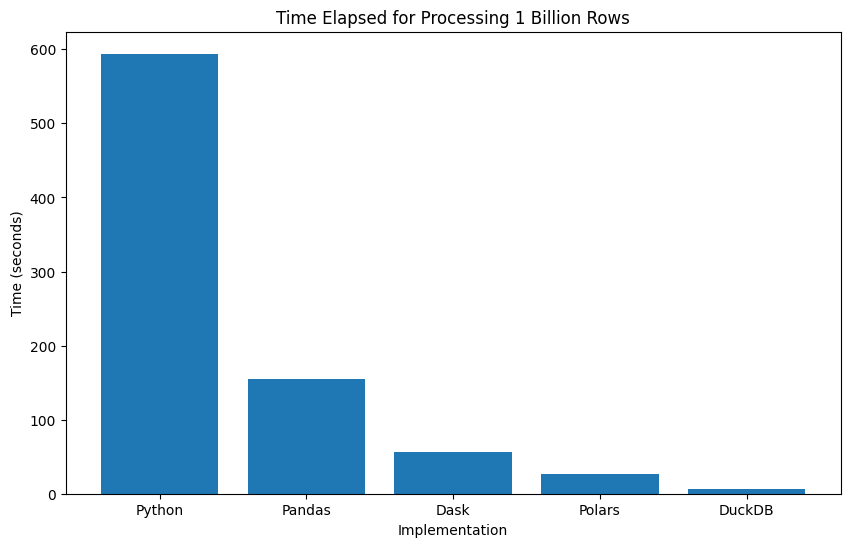

In [44]:
#Plotting the results
import matplotlib.pyplot as plt

# Plotting the implementation comparison
plt.figure(figsize=(10, 6))
plt.bar(['Python', 'Pandas', 'Dask', 'Polars', 'DuckDB'], [594,155,57,27,7])
plt.xlabel('Implementation')
plt.ylabel('Time (seconds)')
plt.title('Time Elapsed for Processing 1 Billion Rows')
plt.show()
